# Overview
This is a simple end to end example of how you can use SAS Viya for analysis
The example follows these steps:
1. Importing the needed Python packages
1. Starting a CAS session on an already running CAS server
1. Load the needed CAS Action Sets
1. Loading data from the local file system to the CAS server
1. Explore the data
1. Impute missing values
1. Partition the data into training and validation partitions
1. Build a gradient boost
1. Assess the model
1. Build ROC and lift charts

## Set up and initialize

Find doc for all the CAS actions [here](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg&docsetTarget=titlepage.htm 
) 

### Documentation Links:
* [SAS® Viya™ 3.2: System Programming Guide](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg&docsetTarget=titlepage.htm)
* [Getting Started with SAS® Viya™ 3.2 for Python](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg3&docsetTarget=titlepage.htm&locale=en)

In this code we import the needed packages and we assign variables for the modeling details that will be used later in the analysis

In [1]:
import os
import pandas as pd
import swat
import sys
from matplotlib import pyplot as plt
%matplotlib inline

target          = "bad"
class_inputs    = ["reason", "job"]
class_vars      = [target] + class_inputs
interval_inputs = ["im_clage", "clno", "im_debtinc", "loan", "mortdue", "value", "im_yoj", "im_ninq", "derog", "im_delinq"]
all_inputs      = interval_inputs + class_inputs

indata = 'hmeq'

## Start CAS session

* Documentation to [Connect and Start a Session](http://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=8.11&docsetId=caspg3&docsetTarget=home.htm&locale=en)

In this code we assign values for the cashost, casport, and casauth values. These are then used to establish a CAS session named `sess`.

In [2]:
# cashost='localhost'
cashost='localhost'
casport=5570
sess = swat.CAS(hostname=cashost, port=casport,  authinfo='/home/centos/.authinfo', caslib="casuser", name="brad")

# Load the needed action sets for this example:
sess.loadactionset('datastep')
sess.loadactionset('datapreprocess')
sess.loadactionset('cardinality')
sess.loadactionset('sampling')
sess.loadactionset('decisiontree')
sess.loadactionset('astore')
sess.loadactionset('percentile')
# show the session details
sess

NOTE: Added action set 'datastep'.
NOTE: Added action set 'datapreprocess'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'decisiontree'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'percentile'.


CAS('localhost', 5570, 'sasdemo', protocol='cas', name='brad', session='6d2fa98b-e9fc-c740-b75f-b0b91a5417ec')

## Load data into CAS



In [3]:
indata = sess.CASTable('hmeq')
if not indata.tableexists().exists:
    indata = sess.upload_file('http://support.sas.com/documentation/onlinedoc/viya/exampledatasets/hmeq.csv', casout=indata)

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(sasdemo).
NOTE: The table HMEQ has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


## Explore and Impute missing values

In [21]:
indata.summary()

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT
0,BAD,0.000000,1.000000,5960.0,0.0,0.199497,1.189000e+03,0.399656,0.005177,1.597245e-01,1.189000e+03,9.517985e+02,200.331950,38.536557,2.720203e-290
1,LOAN,1100.000000,89900.000000,5960.0,0.0,18607.969799,1.109035e+08,11207.480417,145.172668,1.256076e+08,2.812185e+12,7.484958e+11,60.229464,128.178190,0.000000e+00
2,MORTDUE,2063.000000,399550.000000,5442.0,518.0,73760.817200,4.014064e+08,44457.609458,602.652327,1.976479e+09,4.036208e+13,1.075402e+13,60.272664,122.393649,0.000000e+00
3,VALUE,8000.000000,855909.000000,5848.0,112.0,101776.048741,5.951863e+08,57385.775334,750.413385,3.293127e+09,7.983063e+13,1.925491e+13,56.384362,135.626644,0.000000e+00
4,YOJ,0.000000,41.000000,5445.0,515.0,8.922268,4.858175e+04,7.573982,0.102642,5.736521e+01,7.457556e+05,3.122962e+05,84.888530,86.926047,0.000000e+00
5,DEROG,0.000000,10.000000,5252.0,708.0,0.254570,1.337000e+03,0.846047,0.011674,7.157951e-01,4.099000e+03,3.758640e+03,332.343880,21.805933,5.478603e-101
6,DELINQ,0.000000,15.000000,5380.0,580.0,0.449442,2.418000e+03,1.127266,0.015369,1.270728e+00,7.922000e+03,6.835248e+03,250.814336,29.244135,1.326786e-174
7,CLAGE,0.000000,1168.233561,5652.0,308.0,179.766275,1.016039e+06,85.810092,1.141398,7.363372e+03,2.242600e+08,4.161041e+07,47.734255,157.496508,0.000000e+00
8,NINQ,0.000000,17.000000,5450.0,510.0,1.186055,6.464000e+03,1.728675,0.023416,2.988317e+00,2.395000e+04,1.628334e+04,145.749978,50.651202,0.000000e+00
9,CLNO,0.000000,71.000000,5738.0,222.0,21.296096,1.221970e+05,10.138933,0.133848,1.027980e+02,3.192071e+06,5.897519e+05,47.609351,159.106532,0.000000e+00


#### Explore data and plot missing values

In [4]:
tbl_data_card = sess.CASTable('data_card', replace=True)

indata.cardinality.summarize(cardinality=tbl_data_card)

tbl_data_card = tbl_data_card.query('_NMISS_ > 0')
tbl_data_card.head()

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.30558 seconds.


,_VARNAME_,_FMTWIDTH_,_TYPE_,_RLEVEL_,_ORDER_,_MORE_,_CARDINALITY_,_NOBS_,_SUMFREQS_,_NMISS_,...,_SKEWNESS_,_KURTOSIS_,_MFREQ_,_MFREQFOUNDLEVEL_,_MFREQNUM_,_MFREQCHR_,_MFREQCFMT_,_LASTNUM_,_LASTCHR_,_LASTCFMT_
0,MORTDUE,12.0,N,INTERVAL,ASC,Y,30.0,5960.0,5442.0,518.0,...,1.814481,6.481866,5411.0,N,NaN,,,6124.0,,6124
1,VALUE,12.0,N,INTERVAL,ASC,Y,30.0,5960.0,5848.0,112.0,...,3.053344,24.362805,5818.0,N,NaN,,,20631.0,,20631
2,REASON,7.0,C,CLASS,ASC,N,2.0,5960.0,5708.0,252.0,...,NaN,NaN,3928.0,Y,NaN,DebtCon,DebtCon,NaN,HomeImp,HomeImp
3,JOB,7.0,C,CLASS,ASC,N,6.0,5960.0,5681.0,279.0,...,NaN,NaN,2388.0,Y,NaN,Other,Other,NaN,Self,Self
4,YOJ,12.0,N,INTERVAL,ASC,Y,30.0,5960.0,5445.0,515.0,...,0.988460,0.372072,3876.0,N,NaN,,,3.7,,3.7


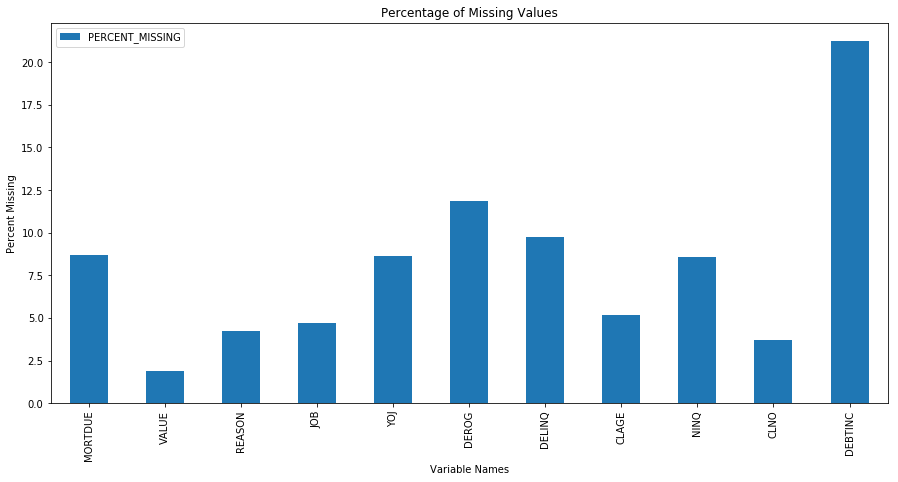

In [5]:
tbl_data_card['PERCENT_MISSING'] = (tbl_data_card['_NMISS_'] / tbl_data_card['_NOBS_']) * 100

ax = tbl_data_card[['_VARNAME_', 'PERCENT_MISSING']].to_frame().set_index('_VARNAME_').plot.bar(
         title='Percentage of Missing Values', figsize=(15,7)
     )
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names');

#### Impute missing values

In [7]:
hmeq_prepped = sess.CASTable('hmeq_prepped', replace=True)
# hmeq_prepped = sess.CASTable('hmeq_prepped', replace=True)

indata.datapreprocess.transform(
    casout=hmeq_prepped,
    copyallvars=True,
    outvarsnameglobalprefix='im',
    requestpackages=[
        {'impute': {'method': 'mean'}, 'inputs': ['clage']},
        {'impute': {'method': 'median'}, 'inputs': ['delinq']},
        {'impute': {'method': 'value', 'valuesNumeric': [2]}, 'inputs': ['ninq']},
        {'impute': {'method': 'value', 'valuesNumeric': [35.0, 7, 2]}, 'inputs': ['debtinc', 'yoj']}
    ]
)

[TransInfo]

 Transformation Requests for HMEQ
 
   ActualName  NTransVars ImputeMethod
 0       _TR1           1         Mean
 1       _TR2           1       Median
 2       _TR3           1        Value
 3       _TR4           2        Value

[VarTransInfo]

 Variable Transformation Information for HMEQ
 
   Variable Transformation   ResultVar     N  NMiss  ImputedValueContinuous
 0    CLAGE             im    im_CLAGE  5652    308              179.766275
 1  DEBTINC             im  im_DEBTINC  4693   1267               35.000000
 2   DELINQ             im   im_DELINQ  5380    580                0.000000
 3     NINQ             im     im_NINQ  5450    510                2.000000
 4      YOJ             im      im_YOJ  5445    515                7.000000

[OutputCasTables]

              casLib          Name  Rows  Columns  \
 0  CASUSER(sasdemo)  hmeq_prepped  5960       18   
 
                                             casTable  
 0  CASTable('hmeq_prepped', caslib='CASUSER(sasde...  

+ Elapsed: 0.0137s, user: 0.0204s, sys: 0.00593s, mem: 11.1mb

## Partition data into Training and Validation

The stratified action in the sampling actionset allows us to create two partition and observe the reponse rate of the target variable `bad` in both training and validation

In [8]:
hmeq_part = sess.CASTable('hmeq_part', replace=True)

hmeq_prepped.groupby(target).sampling.stratified(
  output=dict(casout=hmeq_part, copyvars='all'),
  samppct=70,
  partind=True
)

NOTE: Using SEED=1057848494 for sampling.


[outputSize]

 {'outputNObs': 5960.0, 'outputNVars': 19}

[STRAFreq]

 Frequencies
 
    ByGrpID           BAD  NObs  NSamp
 0        0             0  4771   3340
 1        1             1  1189    832

[OutputCasTables]

              casLib       Name Label  Rows  Columns  \
 0  CASUSER(sasdemo)  hmeq_part        5960       19   
 
                                            casTable  
 0  CASTable('hmeq_part', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0167s, user: 0.014s, sys: 0.00815s, mem: 11.9mb

## Gradient Boosting Machine


In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `gb_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `gb_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [9]:
hmeq_part_1 = hmeq_part.query('_partind_ = 1')
gb_model = sess.CASTable('gb_model', replace=True)
scored_gb = sess.CASTable('_scored_gb', replace=True)
gb_model_astore = sess.CASTable('gb_model_astore', replace=True)

hmeq_part_1.decisiontree.gbtreetrain(
  inputs=all_inputs,
  nominals=class_vars,
  target=target,
  ntree=10,
  nbins=20,
  maxlevel=6,
  varimp=True,
  missing='useinsearch',
  casout=gb_model,
  #save the model state as astore
  savestate={"name": "gb_model_astore",
              "promote": True,
             "caslib":"public"
          }
)

# Score 
hmeq_part.decisionTree.gbtreeScore(
  modeltable=gb_model,
  casout=scored_gb,
  copyvars=[target, '_partind_']
)

gb_model.head()
scored_gb.head()

NOTE: Wrote 383758 bytes to the savestate file gb_model_astore.


,BAD,_PartInd_,_GBT_PredName_,_GBT_PredP_,_GBT_PredLevel_,_MissIt_
0,1.0,0.0,1,0.515288,0.0,0.0
1,1.0,1.0,0,0.599216,1.0,1.0
2,1.0,1.0,1,0.577160,0.0,0.0
3,1.0,1.0,0,0.576095,1.0,1.0
4,0.0,1.0,0,0.842907,1.0,0.0


In [27]:
import json
hmeq_part_1.head().to_json(orient='records')

'[{"BAD":1.0,"LOAN":1100.0,"MORTDUE":25860.0,"VALUE":39025.0,"REASON":"HomeImp","JOB":"Other","YOJ":10.5,"DEROG":0.0,"DELINQ":0.0,"CLAGE":94.3666666667,"NINQ":1.0,"CLNO":9.0,"DEBTINC":null,"im_CLAGE":94.3666666667,"im_DEBTINC":35.0,"im_DELINQ":0.0,"im_NINQ":1.0,"im_YOJ":10.5,"_PartInd_":1.0},{"BAD":1.0,"LOAN":1300.0,"MORTDUE":70053.0,"VALUE":68400.0,"REASON":"HomeImp","JOB":"Other","YOJ":7.0,"DEROG":0.0,"DELINQ":2.0,"CLAGE":121.8333333333,"NINQ":0.0,"CLNO":14.0,"DEBTINC":null,"im_CLAGE":121.8333333333,"im_DEBTINC":35.0,"im_DELINQ":2.0,"im_NINQ":0.0,"im_YOJ":7.0,"_PartInd_":1.0},{"BAD":1.0,"LOAN":1500.0,"MORTDUE":13500.0,"VALUE":16700.0,"REASON":"HomeImp","JOB":"Other","YOJ":4.0,"DEROG":0.0,"DELINQ":0.0,"CLAGE":149.4666666667,"NINQ":1.0,"CLNO":10.0,"DEBTINC":null,"im_CLAGE":149.4666666667,"im_DEBTINC":35.0,"im_DELINQ":0.0,"im_NINQ":1.0,"im_YOJ":4.0,"_PartInd_":1.0},{"BAD":1.0,"LOAN":1800.0,"MORTDUE":48649.0,"VALUE":57037.0,"REASON":"HomeImp","JOB":"Other","YOJ":5.0,"DEROG":3.0,"DELINQ":

In [18]:
# write the model savestate out to the server filesystem
gb_model_astore.table.save(name="gb_model_astore.bin", table=dict(name='gb_model_astore',caslib='public'),caslib="public")

NOTE: Cloud Analytic Services saved the file gb_model_astore.bin.sashdat in caslib Public.


[caslib]

 'Public'

[name]

 'gb_model_astore.bin.sashdat'

+ Elapsed: 0.00741s, user: 0.00197s, sys: 0.00153s, mem: 16.4mb

In [51]:
# download results of astore savestate
results = sess.aStore.download(rstore=dict(name='gb_model_astore',caslib='public'))
list(results.keys())
results['blob'][2]

16

In [50]:
# # model written to local filesystem 
import codecs
blob = sess.aStore.download(rstore=dict(name='gb_model_astore',caslib='public'))['blob']
with open("Output.bin","wb") as output_file:
    output_file.write(blob)
    output_file.close()

In [53]:
f = open("Output.bin","rb")
f.seek(0)
data = f.read()
f.close()
data[2]
# results2 = sess.aStore.upload(rstore=dict(name='gb_model_astore_upload',caslib='public'),store=data)

16

In [34]:
m = sess.describe(rstore=dict(name='gb_model_astore_upload',caslib='PUBLIC'))  
m['Key']

,Key
0,AE480EDAD228EC694CC1AABAB9DD5BB6C9E00B6E


In [19]:
sess.table.fileinfo(caslib="public",path="%")

,Permission,Owner,Group,Name,Size,Encryption,Time
0,-rwxr-xr-x,sasdemo,administrators,gb_model_astore.bin.sashdat,357736,NONE,15Dec2017:21:51:15


## Assess Model

In [ ]:
# Create p_bad0 and p_bad1 as _gbt_predp_ is the probability of event in _gbt_predname_
scored_gb['p_bad1'] = scored_gb.eval("ifn( strip(_gbt_predname_) = '1', _gbt_predp_, 1-_gbt_predp_ )") 
scored_gb['p_bad0'] = scored_gb.eval("ifn( strip(_gbt_predname_) = '0', 1-_gbt_predp_, _gbt_predp_ )")

gb_assess = sess.percentile.assess(
            table=scored_gb.query('_partind_ = 0'),
            inputs=['p_bad1'],      
            response='bad',
            event='1',
            pvar=['p_bad0'],
            pevent=['0']      
        )
 
gb_fitstat  = gb_assess.FitStat
gb_rocinfo  = gb_assess.ROCInfo
gb_liftinfo = gb_assess.LIFTInfo

## Create ROC and Lift plots (using Validation data)

#### Prepare assessment results for plotting

In [ ]:
# Add new variable to indicate type of model
gb_liftinfo['model']   = 'GradientBoosting'
gb_rocinfo['model']    = 'GradientBoosting'

# # Concatenate data
# all_liftinfo = pd.concat([rf_liftinfo, gb_liftinfo, nn_liftinfo, tree_liftinfo], ignore_index=True)
# all_rocinfo = pd.concat([rf_rocinfo, gb_rocinfo, nn_rocinfo, tree_rocinfo], ignore_index=True)

## Draw ROC and Lift plots

In [ ]:
# Draw ROC charts 
plt.figure(figsize=(15, 5))
for key, grp in gb_rocinfo.groupby(['model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label=key)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend(loc='best')
plt.title('ROC Curve')
plt.show()

# Draw lift charts
plt.figure(figsize=(15, 5))
for key, grp in gb_liftinfo.groupby(['model']):
    plt.plot(grp['Depth'], grp['CumLift'], label=key)
plt.xlabel('Depth')
plt.ylabel('Cumulative Lift')
plt.grid(True)
plt.legend(loc='best')
plt.title('Cumulative Lift Chart')
plt.show();

## End CAS session

This closes the CAS session freeing resources for others to leverage

In [ ]:
# This is the same as sess.endsession(); sess.close();
sess.terminate()